In [27]:
import numpy as np
import pandas as pd
import h5py
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
name = 'vanilla_lstm_large'

In [4]:
with open('../reports/{}/losses.pkl'.format(name), 'rb') as f:
    losses = pkl.load(f)

In [11]:
def get_losses(losses_dict):
    gen = [batch_loss for epoch_losses in losses_dict['generator'] for batch_loss in epoch_losses]
    disc = [batch_loss for epoch_losses in losses_dict['discriminator'] for batch_loss in epoch_losses]
    return np.array(gen), np.array(disc)

# Inspect losses

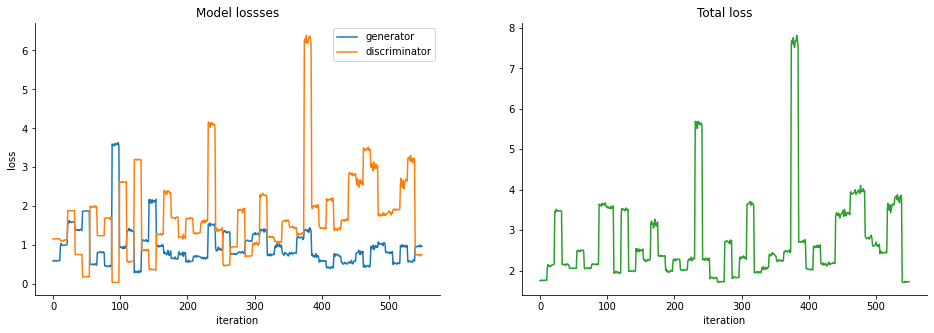

In [12]:
plt.figure(figsize=(16, 5))

gen_losses, disc_losses = get_losses(losses)

ax = plt.subplot(121)
ax.plot(gen_losses, label='generator')
ax.plot(disc_losses, label='discriminator')

ax.set_title('Model lossses')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(122)
ax.plot(gen_losses + disc_losses, c='C2')

ax.set_title('Total loss')
ax.set_xlabel('iteration')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Visually inspect time series

In [33]:
samples_file = '../synthetic/{}/predicted.h5'.format(name)

with h5py.File(samples_file, 'r') as hf:
    x = np.array(hf.get('X'))

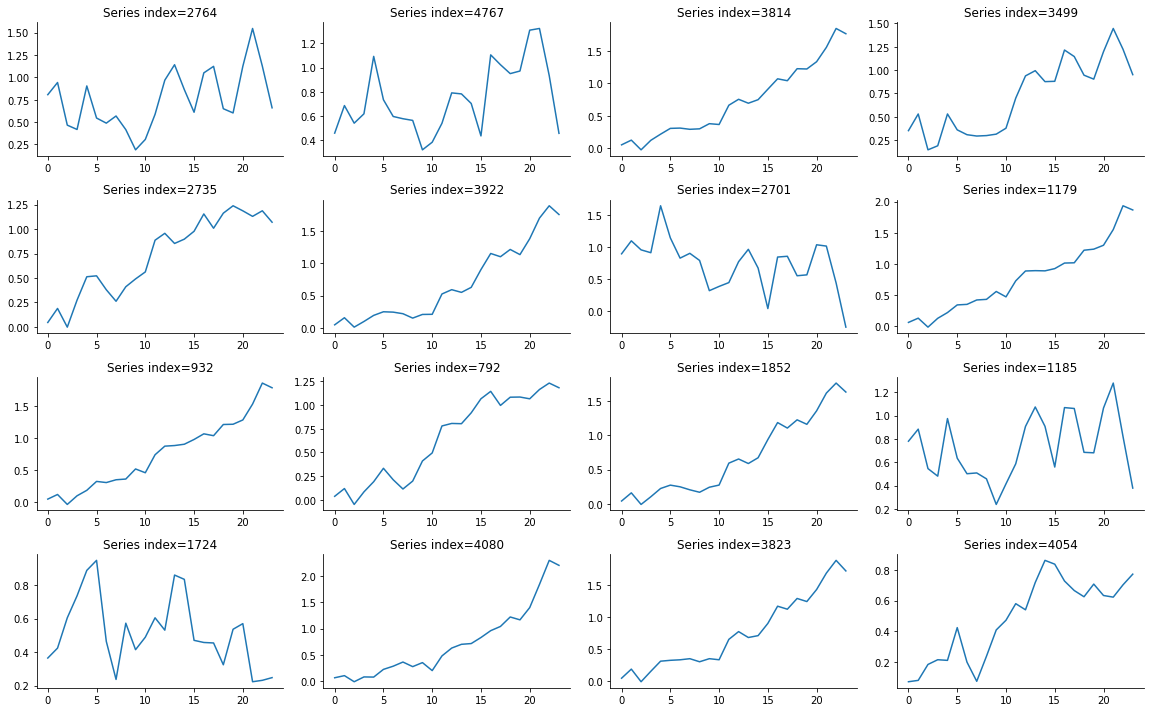

In [36]:
np.random.seed(1)
ind = np.random.permutation(len(x))[:16]

plt.figure(figsize=(16, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    series = x[ind[i]]
    ax.plot(series)
    ax.set_title('Series index={}'.format(ind[i]))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()

# Visualization

In [13]:
with open('../reports/{}/2d_projections.pkl'.format(name), 'rb') as f:
    projections = pkl.load(f)

## PCA

In [29]:
import seaborn as sns

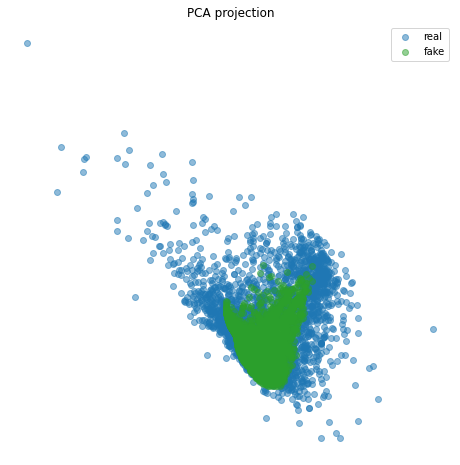

In [42]:
real_2d, fake_2d = projections['pca']

r_x, r_y = real_2d.T
f_x, f_y = fake_2d.T

plt.figure(figsize=(8, 8))

ax = plt.subplot(111)

ax.scatter(r_x, r_y, alpha=0.5, label='real')
ax.scatter(f_x, f_y, alpha=0.5, label='fake', c='C2')

ax.axis('off')
ax.legend()
ax.set_title('PCA projection');




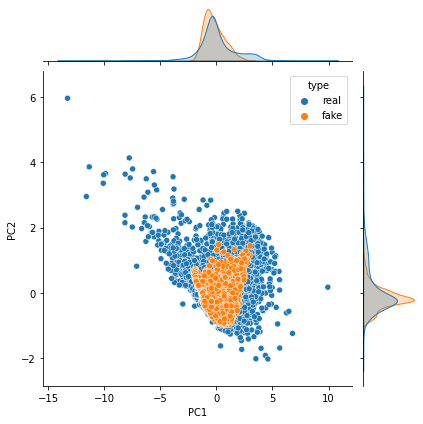

In [45]:
df = pd.DataFrame({'PC1': np.r_[r_x, f_x], 'PC2': np.r_[r_y, f_y], 'type': ['real'] * len(r_x) + ['fake'] * len(f_x)})

sns.jointplot(data=df, x='PC1', y='PC2', hue='type')